In [10]:
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import describe, pearsonr
import datetime
from datetime import timedelta as timedelta
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import signal
import os, sys
sys.path.append( '/home/ugrads/c/clearloveyanzhen/CufflessBP/bioz_processing' )
import sicong_util as su
import sicong_duck_path as sp
import sicong_duck_path as sdp
plt.rcParams.update({'font.size': 13})
import seaborn as sns
import scipy as sp # for signal processing
from scipy import signal
from scipy.spatial import distance
import IPython.display as ipd
import random
import math
import mat73
import h_model

In [11]:
X = np.load('X_file.npy')
y = np.load('y_file.npy')

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader , TensorDataset
import torch.autograd as autograd
from torch import Tensor
    
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [13]:
class LSTM_Model(nn.Module):  # Inherit nn.Module
    def __init__(self, input_size, hidden_units, num_layers):
        super().__init__()
        self.input_size = input_size  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )
        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)
        
    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.
        return out

In [14]:
class MinMaxScaler(object):
    """
    Transforms each channel to the range [0, 1].
    """
    def transform(self, tensor): 
        self.max = tensor.max()
        self.min = tensor.min()
        scale = 1.0 / (tensor.max() - tensor.min())
        tensor.sub_(tensor.min())
        tensor.mul_(scale)
        # tensor.mul_(scale).sub_(tensor.min().mul_(scale))

    def inverse(self, tensor):
        scale = (self.max - self.min)
        tensor.mul_(scale)
        tensor.add_(self.min)
mms = MinMaxScaler()

In [65]:
# xs = MinMaxScaler()
# ys = MinMaxScaler()
bs = 1
idx_pre=3000
input_x = np.reshape(X[:idx_pre,-(bs*300*2):], (-1, 2, 300*bs))
# input_x = np.transpose(input_x, [0,2,1])
input_x = input_x.astype(np.float32)
label_y = y[:idx_pre,0].astype(np.float32)

# input_x = xs.fit_transform(input_x)
# label_y = ys.fit_transform(label_y)

input_x = torch.tensor(input_x)
label_y = torch.tensor(label_y)
mms.transform(label_y)

In [71]:
input_x.shape, label_y.shape

(torch.Size([3000, 2, 300]), torch.Size([3000]))

In [72]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss
    
def test_model(data_loader, model, loss_function, return_pred=False):

    num_batches = len(data_loader)
    total_loss = 0
    output_list = []

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    print(f"Test correlation: {pearsonr(output, y)}")
    if return_pred:
        return avg_loss, output
    return avg_loss


In [73]:
train_portion = int(len(input_x) * 0.7)
train_data = []
for i in range(len(input_x)):
    train_data.append([input_x[i], label_y[i]])
train_loader = torch.utils.data.DataLoader(train_data[:train_portion], shuffle=True, batch_size=10)
test_loader = torch.utils.data.DataLoader(train_data[train_portion:], shuffle=True, batch_size=10)

In [74]:
learning_rate = 1e-5
num_hidden_units = 16
input_size = 2
model = LSTM_Model(input_size=input_size, hidden_units=num_hidden_units, num_layers=2)
model2 = h_model.CNN_RNN(num_feat=300*bs, hidden_dim=10, normalization=None, Use_GRU_LSTM='LSTM', device='cpu')
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [75]:
print("Untrained test\n--------")
test_model(test_loader, model2, loss_function)
print()

Untrained test
--------
Test loss: 0.3049572866823938


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [48]:
print("Untrained test\n--------")
test_model(test_loader, model2, loss_function)
print()

loss_list = []
for ix_epoch in range(50):
    print(f"Epoch {ix_epoch}\n---------")
    loss_list = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 0.2148000108699004
Test correlation: (-0.5305752393820304, 0.11460893399358245)

Epoch 0
---------
Train loss: 0.1763788966905503
Test loss: 0.20252612117264007
Test correlation: (-0.3482763029100707, 0.3240245899611963)

Epoch 1
---------
Train loss: 0.165604312398604
Test loss: 0.19027027090390522
Test correlation: (-0.0937013785450263, 0.7968184153086877)

Epoch 2
---------
Train loss: 0.15491616743661107
Test loss: 0.17804228762785593
Test correlation: (0.18299047063436275, 0.6128451604062248)

Epoch 3
---------
Train loss: 0.1443095709241572
Test loss: 0.16585523237784702
Test correlation: (0.18044652393793087, 0.6178767561873031)

Epoch 4
---------
Train loss: 0.13376716522588616
Test loss: 0.15366063308384684
Test correlation: (-0.2923211898551232, 0.412445129136646)

Epoch 5
---------
Train loss: 0.12327913565649873
Test loss: 0.1413639939493603
Test correlation: (-0.0858634800971186, 0.8135522793861526)

Epoch 6
---------
Train loss: 0.112836


KeyboardInterrupt



In [96]:
# avg_loss, outputs = test_model(test_loader, model, loss_function, return_pred=True)

Test loss: 0.021502546143407623


In [54]:
sec_x = np.reshape(X[idx_pre:idx_pre+150,-(bs*300*2):], (-1, 2, 300*bs))
sec_x = np.transpose(sec_x, [0,2,1])
sec_x = sec_x.astype(np.float32)
sec_y = y[idx_pre:idx_pre+150,0].astype(np.float32)

# input_x = xs.fit_transform(input_x)
# label_y = ys.fit_transform(label_y)

sec_x = torch.tensor(sec_x)
sec_y = torch.tensor(sec_y)
# mms.transform(label_y)


In [61]:
# with torch.no_grad():
#     for a, b in test_loader:
#         output = model(a)
#         # mms.transform(sec_y)
#         loss = loss_function(output, b).item()
#         print('pearson =', pearsonr(output, b))
#         if pearsonr(output, b)[0] > 0.5:
#             break
#     mms.inverse(output)
#     mms.inverse(b)
with torch.no_grad():
    output = model(sec_x)
    mms.transform(sec_y)
    loss = loss_function(output, sec_y).item()
    print('pearson =', pearsonr(output, sec_y))
    
    mms.inverse(output)
    mms.inverse(sec_y)

pearson = (-0.013043219786774817, 0.8741285728169916)


loss = 0.0505482442677021
pearson = (-0.013043219786774817, 0.8741285728169916)


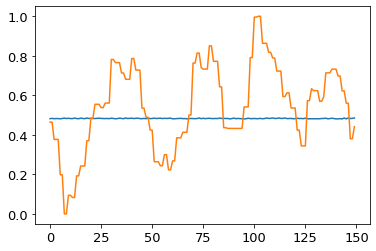

In [62]:
plt.plot(output)
plt.plot(sec_y)
print('loss =',loss)
print('pearson =', pearsonr(output, sec_y))

In [47]:
output

tensor([136.1393, 136.1333, 136.1452, 136.1561, 136.1382, 136.1337, 136.1337,
        136.1463, 136.1356, 136.1332])

In [16]:
with torch.no_grad():
    aa, (bb, cc) = model.lstm(sec_x)

In [17]:
aa.shape, bb.shape, cc.shape,

(torch.Size([150, 300, 32]),
 torch.Size([2, 150, 32]),
 torch.Size([2, 150, 32]))

In [18]:
sec_y.shape

torch.Size([150])

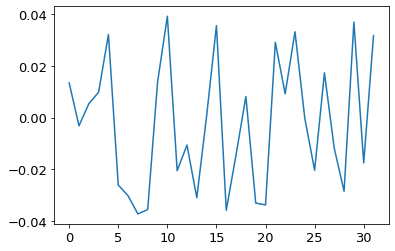

In [19]:
asd = []
for i in range(len(bb[0,0])):
    rr, pp = pearsonr(bb[-1,:,i], sec_y)
    asd.append(rr)
plt.plot(asd)

tensor([0.4643, 0.4643, 0.3769, 0.3769, 0.3769, 0.1979, 0.1979, 0.0000, 0.0000,
        0.0941, 0.0941, 0.0831, 0.0831, 0.1924, 0.1924, 0.2425, 0.2425, 0.2425,
        0.3702, 0.3702, 0.4844, 0.4844, 0.5547, 0.5547, 0.5547, 0.5376, 0.5376,
        0.5608, 0.5608, 0.5608, 0.7813, 0.7813, 0.7654, 0.7654, 0.7654, 0.7129,
        0.7129, 0.6811, 0.6811, 0.6811, 0.7862, 0.7862, 0.7276, 0.7276, 0.7276,
        0.5351, 0.5351, 0.4887, 0.4887, 0.4239, 0.4239, 0.2639, 0.2639, 0.2639,
        0.2437, 0.2437, 0.2999, 0.2999, 0.2230, 0.2230, 0.2682, 0.2682, 0.3849,
        0.3849, 0.3849, 0.4130, 0.4130, 0.4130, 0.5003, 0.5003, 0.7630, 0.7630,
        0.8137, 0.8137, 0.7404, 0.7324, 0.7324, 0.7324, 0.8503, 0.8503, 0.7721,
        0.7721, 0.7721, 0.6426, 0.6426, 0.4362, 0.4362, 0.4325, 0.4325, 0.4325,
        0.4325, 0.4325, 0.4325, 0.4325, 0.4325, 0.5412, 0.5412, 0.5412, 0.7911,
        0.7911, 0.9957, 0.9957, 1.0000, 1.0000, 0.8632, 0.8632, 0.8632, 0.8173,
        0.8173, 0.7886, 0.7886, 0.7227, 